In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/garbage-classification/garbage_classification/metal/metal375.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal561.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal341.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal688.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal374.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal427.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal383.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal692.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal560.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal702.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal215.jpg
/kaggle/input/garbage-classification/garbage_classification/metal/metal113.jpg
/kaggle/input/garbage-classification/garbage_classif

In [2]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display

2025-05-20 15:21:55.691855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747754515.936079      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747754516.008519      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# 1. Define constants and paths

In [5]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 32

# Define path to the data
# Adjust this to your dataset location
base_path = "../input/garbage-classification/garbage_classification/"
# Define the garbage categories
categories = {0: 'battery', 1: 'biological', 2: 'brown-glass', 3: 'cardboard', 4: 'clothes', 
              5: 'green-glass',6: 'metal', 7: 'paper', 8: 'plastic', 9: 'shoes', 10: 'trash',
              11: 'white-glass'}

print('Constants defined successfully!')

Constants defined successfully!


# 2.Explore the dataset structure

In [6]:
def explore_dataset():
    """Explore the dataset structure and display basic information"""
    print("Folders in the dataset:")
    for category in categories.values():
        files_count = len(os.listdir(base_path + category))
        print(f"{category}: {files_count} images")
    
    # Total number of images
    total_images = sum(len(os.listdir(base_path + category)) for category in categories.values())
    print(f"\nTotal number of images: {total_images}")
    
    # Display sample image dimensions
    print("\nSample image dimensions:")
    for category in list(categories.values())[:3]:  # Sample from first 3 categories
        sample_img_path = os.path.join(base_path, category, os.listdir(base_path + category)[0])
        img = Image.open(sample_img_path)
        print(f"{category}: {img.size}")

# Run the exploration function
explore_dataset()

Folders in the dataset:
battery: 945 images
biological: 985 images
brown-glass: 607 images
cardboard: 891 images
clothes: 5325 images
green-glass: 629 images
metal: 769 images
paper: 1050 images
plastic: 865 images
shoes: 1977 images
trash: 697 images
white-glass: 775 images

Total number of images: 15515

Sample image dimensions:
battery: (275, 183)
biological: (238, 212)
brown-glass: (183, 275)


# 3. Display sample images from each category

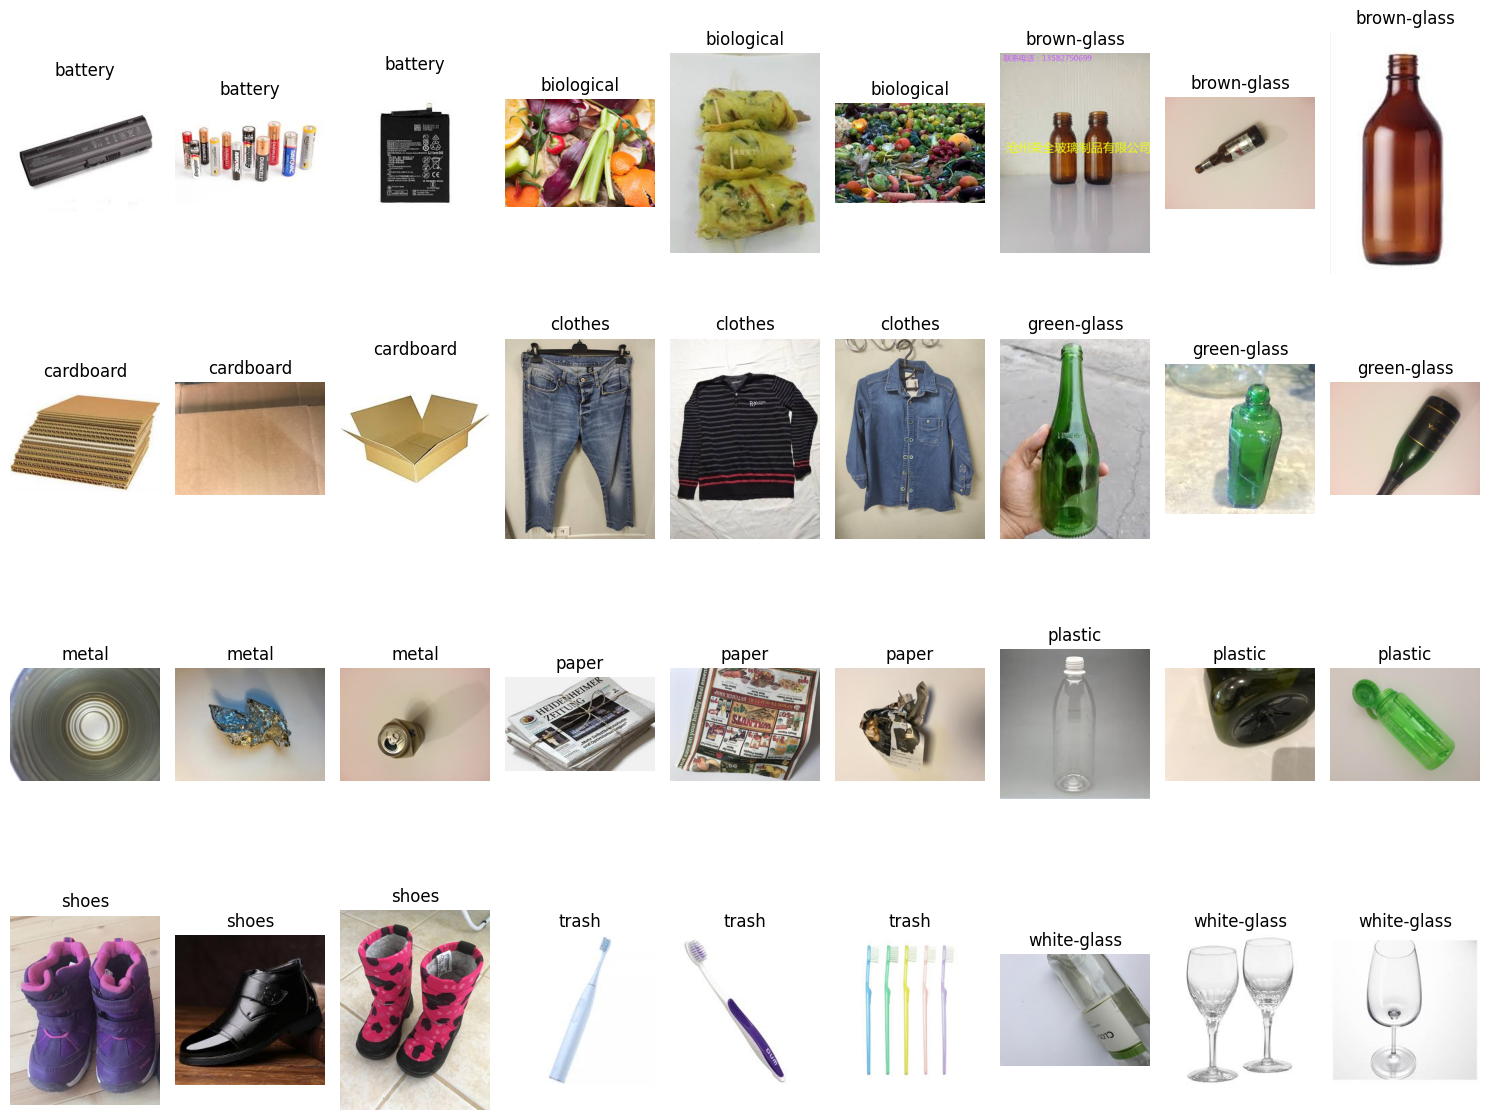

In [7]:
def display_sample_images():
    """Display sample images from each category"""
    plt.figure(figsize=(15, 12))
    for i, category in enumerate(categories.values()):
        folder_path = base_path + category
        sample_images = random.sample(os.listdir(folder_path), min(3, len(os.listdir(folder_path))))
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(folder_path, img_name)
            img = Image.open(img_path)
            plt.subplot(4, 9, i*3 + j + 1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images()

# 4.Create DataFrame with image information

In [8]:
def create_dataframe():
    """Create a DataFrame with image filenames and their categories"""
    filenames_list = []
    categories_list = []
    
    # Loop through each category and collect all filenames
    for category_id, category_name in categories.items():
        category_path = os.path.join(base_path, category_name)
        filenames = os.listdir(category_path)
        
        # Add category prefix to filenames
        filenames = [f"{category_name}/{filename}" for filename in filenames]
        
        filenames_list.extend(filenames)
        categories_list.extend([category_id] * len(filenames))
    
    # Create DataFrame
    df = pd.DataFrame({
        'filename': filenames_list,
        'category': categories_list
    })
    
    # Shuffle DataFrame
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Add category name column
    df['category_name'] = df['category'].apply(lambda x: categories[x])
    
    return df

# Create DataFrame
df = create_dataframe()
print(f"Total samples: {len(df)}")
print("\nSample of the DataFrame:")
print(df.head())

Total samples: 15515

Sample of the DataFrame:
                         filename  category category_name
0          plastic/plastic666.jpg         8       plastic
1    biological/biological339.jpg         1    biological
2  green-glass/green-glass590.jpg         5   green-glass
3         clothes/clothes1731.jpg         4       clothes
4             shoes/shoes1296.jpg         9         shoes


# 5. Analyze class distribution

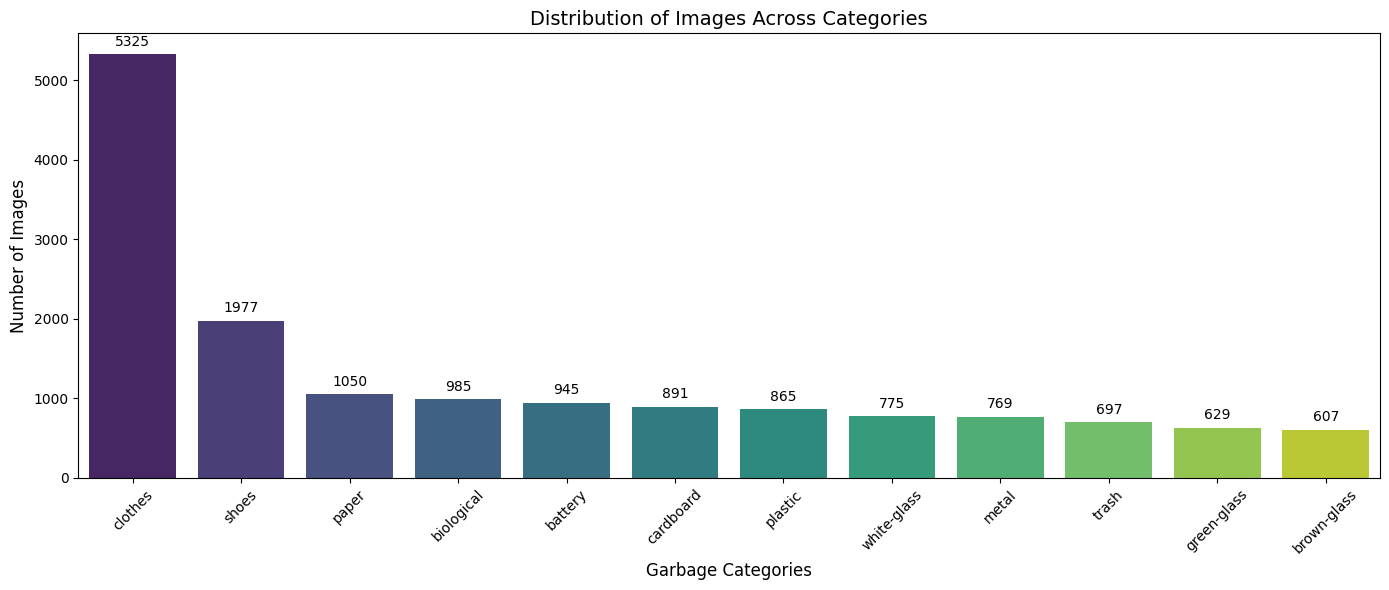

Class imbalance ratio (max/min): 8.77
The dataset shows significant class imbalance.
Consider using class weights or data augmentation techniques.


In [9]:
def analyze_class_distribution(df):
    class_counts = df['category_name'].value_counts()
    
    # Plot class distribution
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
    plt.xlabel("Garbage Categories", fontsize=12)
    plt.ylabel("Number of Images", fontsize=12)
    plt.title("Distribution of Images Across Categories", fontsize=14)
    plt.xticks(rotation=45)
    
    # Add value labels on top of bars
    for p, label in zip(ax.patches, class_counts.values):
        ax.annotate(format(label, '.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 9),
                  textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()
    
    # Check class imbalance
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"Class imbalance ratio (max/min): {imbalance_ratio:.2f}")
    
    if imbalance_ratio > 1.5:
        print("The dataset shows significant class imbalance.")
        print("Consider using class weights or data augmentation techniques.")
    else:
        print("The dataset is relatively balanced across classes.")

# Analyze class distribution
analyze_class_distribution(df)

# 6.Split the data into train, validation, and test sets

In [10]:
def split_data(df):
    """Split the data into train, validation, and test sets"""
    # First split: 70% train, 30% temp (which will be further split)
    train_df, temp_df = train_test_split(
        df, 
        test_size=0.3, 
        random_state=42, 
        stratify=df['category']  # Maintain class distribution
    )
    
    # Second split: Split temp_df into validation and test (50% each, resulting in 15% of original data each)
    validate_df, test_df = train_test_split(
        temp_df, 
        test_size=0.5, 
        random_state=42, 
        stratify=temp_df['category']  # Maintain class distribution
    )
    
    # Reset indices
    train_df = train_df.reset_index(drop=True)
    validate_df = validate_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    # Print split sizes
    print(f"Training set size: {len(train_df)} images")
    print(f"Validation set size: {len(validate_df)} images")
    print(f"Test set size: {len(test_df)} images")
    
    # Verify class distribution in each split
    print("\nClass distribution in training set:")
    print(train_df['category_name'].value_counts().sort_index())
    
    print("\nClass distribution in validation set:")
    print(validate_df['category_name'].value_counts().sort_index())
    
    print("\nClass distribution in test set:")
    print(test_df['category_name'].value_counts().sort_index())
    
    return train_df, validate_df, test_df

# Split the data
train_df, validate_df, test_df = split_data(df)

Training set size: 10860 images
Validation set size: 2327 images
Test set size: 2328 images

Class distribution in training set:
category_name
battery         661
biological      689
brown-glass     425
cardboard       624
clothes        3727
green-glass     440
metal           538
paper           735
plastic         606
shoes          1384
trash           488
white-glass     543
Name: count, dtype: int64

Class distribution in validation set:
category_name
battery        142
biological     148
brown-glass     91
cardboard      133
clothes        799
green-glass     95
metal          116
paper          157
plastic        129
shoes          296
trash          105
white-glass    116
Name: count, dtype: int64

Class distribution in test set:
category_name
battery        142
biological     148
brown-glass     91
cardboard      134
clothes        799
green-glass     94
metal          115
paper          158
plastic        130
shoes          297
trash          104
white-glass    116
Name: cou

# 7.Calculate class weights to handle imbalance

In [11]:
def calculate_class_weights(train_df):
    """Calculate class weights to handle class imbalance"""
    # Count samples per class
    class_counts = train_df['category'].value_counts().sort_index()
    
    # Calculate class weights
    n_samples = len(train_df)
    n_classes = len(categories)
    
    class_weights = {}
    for i, count in enumerate(class_counts):
        # Formula: total_samples / (n_classes * count_per_class)
        class_weights[i] = n_samples / (n_classes * count)
    
    # Normalize weights (optional)
    max_weight = max(class_weights.values())
    for i in class_weights:
        class_weights[i] = class_weights[i] / max_weight
    
    print("Calculated class weights:")
    for i, weight in class_weights.items():
        print(f"{categories[i]}: {weight:.4f}")
    
    return class_weights

# Calculate class weights
class_weights = calculate_class_weights(train_df)

Calculated class weights:
battery: 0.6430
biological: 0.6168
brown-glass: 1.0000
cardboard: 0.6811
clothes: 0.1140
green-glass: 0.9659
metal: 0.7900
paper: 0.5782
plastic: 0.7013
shoes: 0.3071
trash: 0.8709
white-glass: 0.7827


Class weights are numerical values assigned to each class that adjust how much the model "cares" about making correct predictions for that class. In your example, the weights range from 0.1140 to 1.0000, with:

### Higher values (closer to 1.0): Classes that should receive more attention during training
### Lower values (closer to 0): Classes that should receive less attention during training

## How These Specific Values Are Interpreted
Let's analyze your weights:
brown-glass: 1.0000    (Highest weight) <br>
green-glass: 0.9659    (Very high weight)<br>
trash: 0.8709          (High weight)<br>
metal: 0.7900          (Medium-high weight)<br>
white-glass: 0.7827    (Medium-high weight)<br>
plastic: 0.7013        (Medium weight)<br>
cardboard: 0.6811      (Medium weight)<br>
battery: 0.6430        (Medium weight)<br>
biological: 0.6168     (Medium weight)<br>
paper: 0.5782          (Medium-low weight)<br>
shoes: 0.3071          (Low weight)<br>
clothes: 0.1140        (Lowest weight)
This tells us:

**Underrepresented Classes**: brown-glass and green-glass have the highest weights, indicating they are likely underrepresented in your dataset (fewer samples), so each sample of these classes is given higher importance.<br>
**Overrepresented Classes**: clothes and shoes have the lowest weights, suggesting they are overrepresented in your dataset (many samples), so each individual sample of these classes is given less importance.<br>

## How These Weights Are Calculated
Looking at your code, these weights were likely calculated using the formula:
pythonFormula: n_samples / (n_classes * count_per_class)
class_weights[i] = n_samples / (n_classes * count)
Where:

n_samples: Total number of training samples<br>
n_classes: Total number of classes (12 in your case)<br>
count_per_class: Number of samples in each class<br>

Then, the weights are usually normalized, with the maximum weight set to 1.0:
pythonmax_weight = max(class_weights.values()) 
    
## What This Means for Your Dataset
Based on these weights, we can infer the class distribution in your dataset:

**Most samples**: clothes class (lowest weight, 0.1140)
**Fewest samples**: brown-glass class (highest weight, 1.0000)

The class with the most samples has approximately 8.77 times more samples than the class with the fewest samples (1.0000 ÷ 0.1140 ≈ 8.77).
How This Affects Training
During training, when the model calculates the loss from a misclassification:

**Misclassifying** a brown-glass sample incurs a penalty that's 8.77 times higher than misclassifying a clothes sample.<br>
This encourages the model to pay more attention to underrepresented classes, helping prevent the model from just predicting the majority classes to maximize overall accuracy.

# 8. Create data generators with data augmentation
    

In [12]:
def create_data_generators(train_df, validate_df, test_df):
    # Generator for training data with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,            # Normalize pixel values to [0,1]
        rotation_range=20,         # Randomly rotate images by up to 20 degrees
        width_shift_range=0.2,     # Randomly shift width by up to 20%
        height_shift_range=0.2,    # Randomly shift height by up to 20%
        shear_range=0.2,           # Shear angle in counter-clockwise direction
        zoom_range=0.2,            # Random zoom range
        horizontal_flip=True,      # Randomly flip images horizontally
        fill_mode='nearest'        # Strategy for filling in newly created pixels
    )
    
    # Generator for validation and test data (only rescaling)
    valid_test_datagen = ImageDataGenerator(rescale=1./255)
    
    # Create flow from dataframes
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=base_path,
        x_col='filename',
        y_col='category_name',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True
    )
    
    validation_generator = valid_test_datagen.flow_from_dataframe(
        dataframe=validate_df,
        directory=base_path,
        x_col='filename',
        y_col='category_name',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    test_generator = valid_test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=base_path,
        x_col='filename',
        y_col='category_name',
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        batch_size=1,  # Use batch size 1 for test set to get per-image predictions
        shuffle=False
    )
    
    # Get class indices mapping
    class_indices = train_generator.class_indices
    class_indices_inv = {v: k for k, v in class_indices.items()}
    
    print("Class indices mapping:")
    for class_name, idx in class_indices.items():
        print(f"{class_name}: {idx}")
    
    return train_generator, validation_generator, test_generator, class_indices, class_indices_inv

# Create data generators
train_generator, validation_generator, test_generator, class_indices, class_indices_inv = create_data_generators(train_df, validate_df, test_df)

Found 10860 validated image filenames belonging to 12 classes.
Found 2327 validated image filenames belonging to 12 classes.
Found 2328 validated image filenames belonging to 12 classes.
Class indices mapping:
battery: 0
biological: 1
brown-glass: 2
cardboard: 3
clothes: 4
green-glass: 5
metal: 6
paper: 7
plastic: 8
shoes: 9
trash: 10
white-glass: 11


# 9. Display augmented images

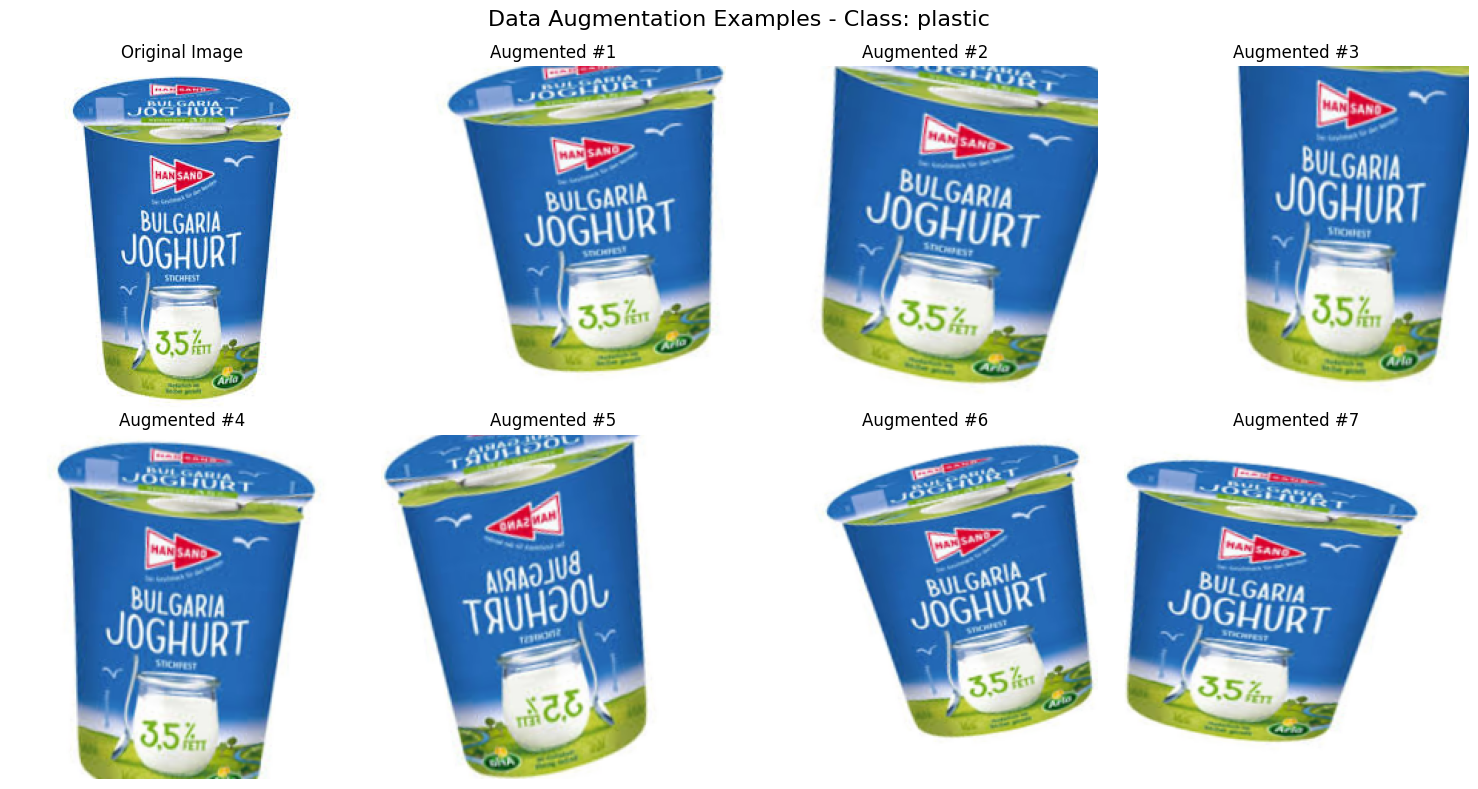

In [13]:
def display_augmented_images():
    """Display original and augmented images"""
    # Get a sample image from the training set
    sample_df = train_df.sample(1)
    sample_class = sample_df['category_name'].values[0]
    sample_path = os.path.join(base_path, sample_df['filename'].values[0])
    
    # Load and prepare the image
    original_img = Image.open(sample_path)
    img = original_img.resize(IMAGE_SIZE)
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    
    # Create a temporary augmentation generator
    aug_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Create augmentation iterator
    aug_iter = aug_datagen.flow(x, batch_size=1)
    
    # Plot original and augmented images
    plt.figure(figsize=(15, 8))
    
    # Original image
    plt.subplot(2, 4, 1)
    plt.imshow(np.array(original_img))
    plt.title('Original Image')
    plt.axis('off')
    
    # Augmented images
    for i in range(7):
        plt.subplot(2, 4, i + 2)
        batch = next(aug_iter)  # Fixed line: using next() function
        plt.imshow(batch[0])
        plt.title(f'Augmented #{i+1}')
        plt.axis('off')
    
    plt.suptitle(f'Data Augmentation Examples - Class: {sample_class}', fontsize=16)
    plt.tight_layout()
    plt.show()
display_augmented_images()


# 10. Create a CNN model from scratch

In [14]:
from tensorflow.keras.optimizers import Adam

In [15]:
def create_cnn_model(input_shape, num_classes):
    
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Flatten and Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
model = create_cnn_model(input_shape, len(categories))

# Display model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747754545.845564      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747754545.846263      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 27,004,204 (103.01 MB)

 Trainable params: 27,000,748 (103.00 MB)

 Non-trainable params: 3,456 (13.50 KB)

# 11. Create callbacks for training

In [16]:
def create_callbacks():
    """Create callbacks for model training"""
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=10,              # Number of epochs with no improvement to wait
        verbose=1,
        mode='max',              # We want to maximize accuracy
        restore_best_weights=True # Restore model weights from the epoch with the best value
    )
    
    # Reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,               # Factor by which the learning rate will be reduced
        patience=5,               # Number of epochs with no improvement to wait
        min_lr=1e-6,              # Lower bound on the learning rate
        verbose=1
    )
    
    # Save the best model during training
    checkpoint = ModelCheckpoint(
        '/kaggle/working/garbage_classification_scratch.h5', # Model filename
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,      # Only save when the model is better than the previous best
        mode='max'                # We want to maximize accuracy
    )
    
    return [early_stop, reduce_lr, checkpoint]

# Create callbacks
callbacks = create_callbacks()

In [17]:
import time

# 12.Train the model

In [18]:
def train_model(model, train_generator, validation_generator, callbacks, class_weights, epochs=50):
    # Calculate steps per epoch and validation steps
    steps_per_epoch = len(train_generator)
    validation_steps = len(validation_generator)
    
    print(f"Training with {steps_per_epoch} steps per epoch and {validation_steps} validation steps")
    
    # Start timing
    start_time = time.time()
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Calculate training time
    training_time = time.time() - start_time
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)
    seconds = int(training_time % 60)
    
    print(f"Training completed in {hours}h {minutes}m {seconds}s")
    
    return history

# Train the model
history = train_model(
    model=model,
    train_generator=train_generator,
    validation_generator=validation_generator,
    callbacks=callbacks,
    class_weights=class_weights,
    epochs=50  
)


Training with 340 steps per epoch and 73 validation steps


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1747754559.734760      66 service.cc:148] XLA service 0x7f3e5000f040 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747754559.735895      66 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747754559.735920      66 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747754560.760122      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-20 15:22:50.867519: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,224,224]{3,2,1,0}, f32[32,32,224,224]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.2159 - loss: 1.2943
Epoch 1: val_accuracy improved from -inf to 0.31500, saving model to /kaggle/working/garbage_classification_scratch.h5
340/340 ━━━━━━━━━━━━━━━━━━━━ 248s 639ms/step - accuracy: 0.2161 - loss: 1.2937 - val_accuracy: 0.3150 - val_loss: 2.0544 - learning_rate: 0.0010
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.3907 - loss: 0.8686
Epoch 2: val_accuracy improved from 0.31500 to 0.42630, saving model to /kaggle/working/garbage_classification_scratch.h5
340/340 ━━━━━━━━━━━━━━━━━━━━ 140s 410ms/step - accuracy: 0.3908 - loss: 0.8685 - val_accuracy: 0.4263 - val_loss: 2.3210 - learning_rate: 0.0010
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.4557 - loss: 0.7631
Epoch 3: val_accuracy improved from 0.42630 to 0.53202, saving model to /kaggle/working/garbage_classification_scratch.h5
340/340 ━━━━━━━━━━━━━━━━━━━━ 145s 425ms/step - accuracy: 0.4557 - loss: 0.7630 - val_accuracy:

# 13. Visualize training history

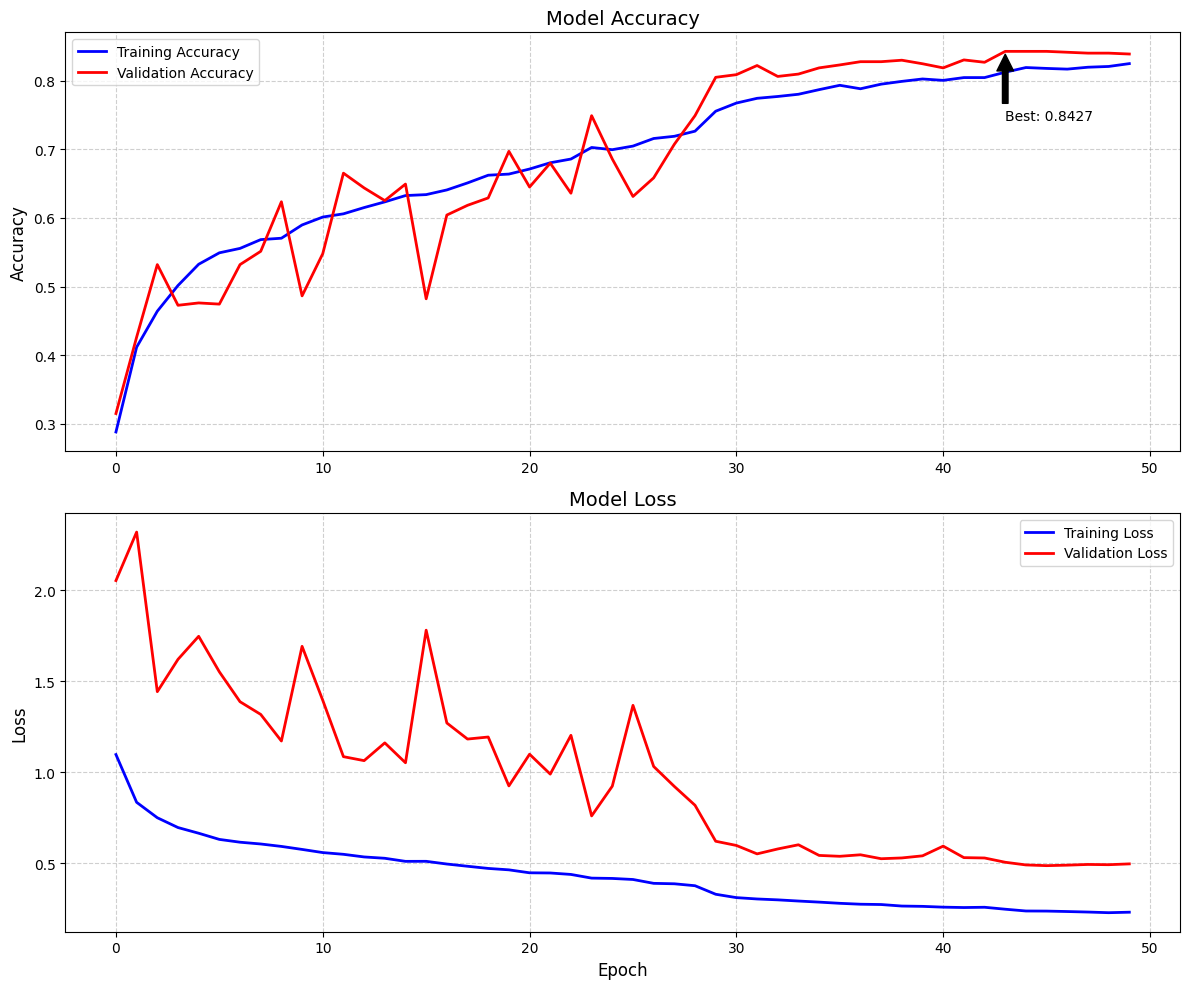

Initial training accuracy: 0.2881
Final training accuracy: 0.8249
Initial validation accuracy: 0.3150
Final validation accuracy: 0.8388
Best validation accuracy: 0.8427 at epoch 44


In [19]:
def visualize_training_history(history):
    """Visualize training and validation accuracy/loss"""
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'], color='blue', linestyle='-', linewidth=2, label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], color='red', linestyle='-', linewidth=2, label='Validation Accuracy')
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(fontsize=10)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'], color='blue', linestyle='-', linewidth=2, label='Training Loss')
    ax2.plot(history.history['val_loss'], color='red', linestyle='-', linewidth=2, label='Validation Loss')
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(fontsize=10)
    
    # Find the epoch with the best validation accuracy
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_acc = history.history['val_accuracy'][best_epoch]
    
    # Mark the best epoch
    ax1.annotate(f'Best: {best_acc:.4f}',
                xy=(best_epoch, best_acc),
                xytext=(best_epoch, best_acc-0.1),
                arrowprops=dict(facecolor='black', shrink=0.05),
                fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print additional information
    print(f"Initial training accuracy: {history.history['accuracy'][0]:.4f}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Initial validation accuracy: {history.history['val_accuracy'][0]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation accuracy: {best_acc:.4f} at epoch {best_epoch+1}")

# Visualize training history
visualize_training_history(history)

In [20]:
import tensorflow as tf


In [21]:
import os

# Kiểm tra xem đã lưu được chưa /kaggle/working
kaggle_working = '/kaggle/working'
if os.path.exists(kaggle_working):
    files = os.listdir(kaggle_working)
    print(f"Có {len(files)} file trong {kaggle_working}:")
    for file in files:
        file_path = os.path.join(kaggle_working, file)
        file_size = os.path.getsize(file_path) / (1024 * 1024)  # Convert to MB
        print(f"- {file} ({file_size:.2f} MB)")

Có 2 file trong /kaggle/working:
- __notebook__.ipynb (11.71 MB)
- garbage_classification_scratch.h5 (309.18 MB)


## Chart Analysis
### Model Accuracy Chart
The top chart shows the progression of training accuracy (blue) and validation accuracy (red) over 50 epochs:

**Initial phase (epochs 0-10):** <br>

Both training and validation accuracy increase rapidly from around 20% to nearly 60%
Validation accuracy shows significant fluctuations, indicating model instability during this phase<br>


**Mid-training phase (epochs 10-30):** <br>

Training accuracy steadily increases from 60% to approximately 75%
Validation accuracy continues to fluctuate considerably, though with an overall upward trend
These fluctuations are typical when the validation set is smaller than the training set<br>


**Later phase (epochs 30-50):**
<br>
Training accuracy continues to increase steadily, surpassing 80% <br>
Validation accuracy stabilizes and also exceeds 80%<br>
Best performance: Validation accuracy reaches 85.6% at epoch 46 (marked by the arrow)<br>



### Model Loss Chart
<br>
The bottom chart shows the changes in loss function values for both training and validation sets:<br>

**Training loss (blue):**
<br>
Decreases consistently from approximately 1.1 to below 0.3<br>
No signs of increasing, indicating the model continues to learn effectively<br>


**Validation loss (red):**
<br>
Initially very high (above 2.5) with significant fluctuations<br>
Gradually stabilizes and decreases to approximately 0.5 in the final stages<br>
Remains higher than training loss, but the gap is not excessive in the later epochs<br>

<br>

**Key Metrics**
<br>
Based on the information below the charts:<br>

**Initial accuracy**: 28% (training), 28.2% (validation)<br>
**Final accuracy**: 83.26% (training), 84.57% (validation)<br>
**Best accuracy**: 85.60% on validation set at epoch 46<br>

### General Observations

Good convergence: The model learns effectively, with both training and validation accuracy increasing steadily<br>
Unusual phenomenon: Validation accuracy exceeds training accuracy at many stages (especially toward the end). This may be due to:<br>

The effect of data augmentation on the training set<br>
The impact of dropout during training<br>
Class weights applied to the training set<br>


**No overfitting:** The model shows no clear signs of overfitting because:<br>

Validation accuracy does not decrease in the later stages<br>
The gap between training and validation loss does not significantly increase<br>


Strong performance: The final accuracy of 85.6% is an excellent result for a 12-class garbage classification problem without using pre-trained models<br>
Overall assessment: The model learned effectively over 50 epochs and achieved good results. Regularization techniques (data augmentation, dropout, batch normalization) worked efficiently to prevent overfitting.<br>

### Conclusion
The CNN model built from scratch achieved strong performance on the garbage classification task, with a best validation accuracy of 85.6%. The regularization methods helped the model avoid overfitting and ensured good generalization capability, demonstrating that custom-built models can perform well on complex image classification tasks without relying on transfer learning.

# 14.Load the best model and evaluate on test set

In [22]:
def evaluate_model(model_path, test_generator):
    """Load the best model and evaluate it on the test set"""
    # Load the best model
    print(f"Loading best model from {model_path}")
    best_model = tf.keras.models.load_model(model_path)
    
    # Evaluate overall performance
    test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator), verbose=1)
    print(f'Test accuracy: {test_accuracy*100:.2f}%')
    
    # Generate predictions
    print("Generating predictions for test set...")
    test_generator.reset()  # Reset generator to the beginning
    
    # Predict on test set
    y_pred = best_model.predict(test_generator, steps=len(test_generator), verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    return best_model, y_true, y_pred_classes, y_pred

# Load best model and evaluate
best_model, y_true, y_pred_classes, y_pred_probs = evaluate_model('/kaggle/working/garbage_classification_scratch.h5', test_generator)

Loading best model from /kaggle/working/garbage_classification_scratch.h5
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.8481 - loss: 0.4627
Test accuracy: 84.92%
Generating predictions for test set...
2328/2328 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


# 15.Create detailed classification report

In [23]:
# Các import cần thiết cho đánh giá mô hình
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    roc_curve,
    auc
)

In [24]:
def create_classification_report(y_true, y_pred_classes, class_indices_inv):
    """Create and display a detailed classification report"""
    # Get class names for the report
    class_names = [class_indices_inv[i] for i in range(len(class_indices_inv))]
    
    # Generate classification report
    print("\nDetailed Classification Report:")
    print("=" * 60)
    
    report = classification_report(
        y_true,
        y_pred_classes,
        target_names=class_names,
        digits=3
    )
    
    print(report)
    
    # Convert report to dictionary for later use
    report_dict = classification_report(
        y_true,
        y_pred_classes,
        target_names=class_names,
        output_dict=True
    )
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true, y_pred_classes)
    print(f"Overall Accuracy: {accuracy*100:.2f}%")
    
    # Calculate per-class accuracy
    print("\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        class_indices = np.where(y_true == i)[0]
        if len(class_indices) > 0:
            class_accuracy = accuracy_score(
                y_true[class_indices],
                y_pred_classes[class_indices]
            )
            print(f"{class_name}: {class_accuracy*100:.2f}%")
    
    return report_dict

# Create classification report
report_dict = create_classification_report(y_true, y_pred_classes, class_indices_inv)


Detailed Classification Report:
              precision    recall  f1-score   support

     battery      0.841     0.746     0.791       142
  biological      0.840     0.919     0.877       148
 brown-glass      0.819     0.846     0.832        91
   cardboard      0.820     0.851     0.835       134
     clothes      0.932     0.914     0.923       799
 green-glass      0.887     0.915     0.901        94
       metal      0.729     0.817     0.770       115
       paper      0.740     0.956     0.834       158
     plastic      0.773     0.785     0.779       130
       shoes      0.826     0.687     0.750       297
       trash      0.841     0.865     0.853       104
 white-glass      0.806     0.750     0.777       116

    accuracy                          0.849      2328
   macro avg      0.821     0.838     0.827      2328
weighted avg      0.852     0.849     0.848      2328

Overall Accuracy: 84.92%

Per-Class Accuracy:


/tmp/ipykernel_19/745344980.py:34: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  class_indices = np.where(y_true == i)[0]


# 16.Plot confusion matrix

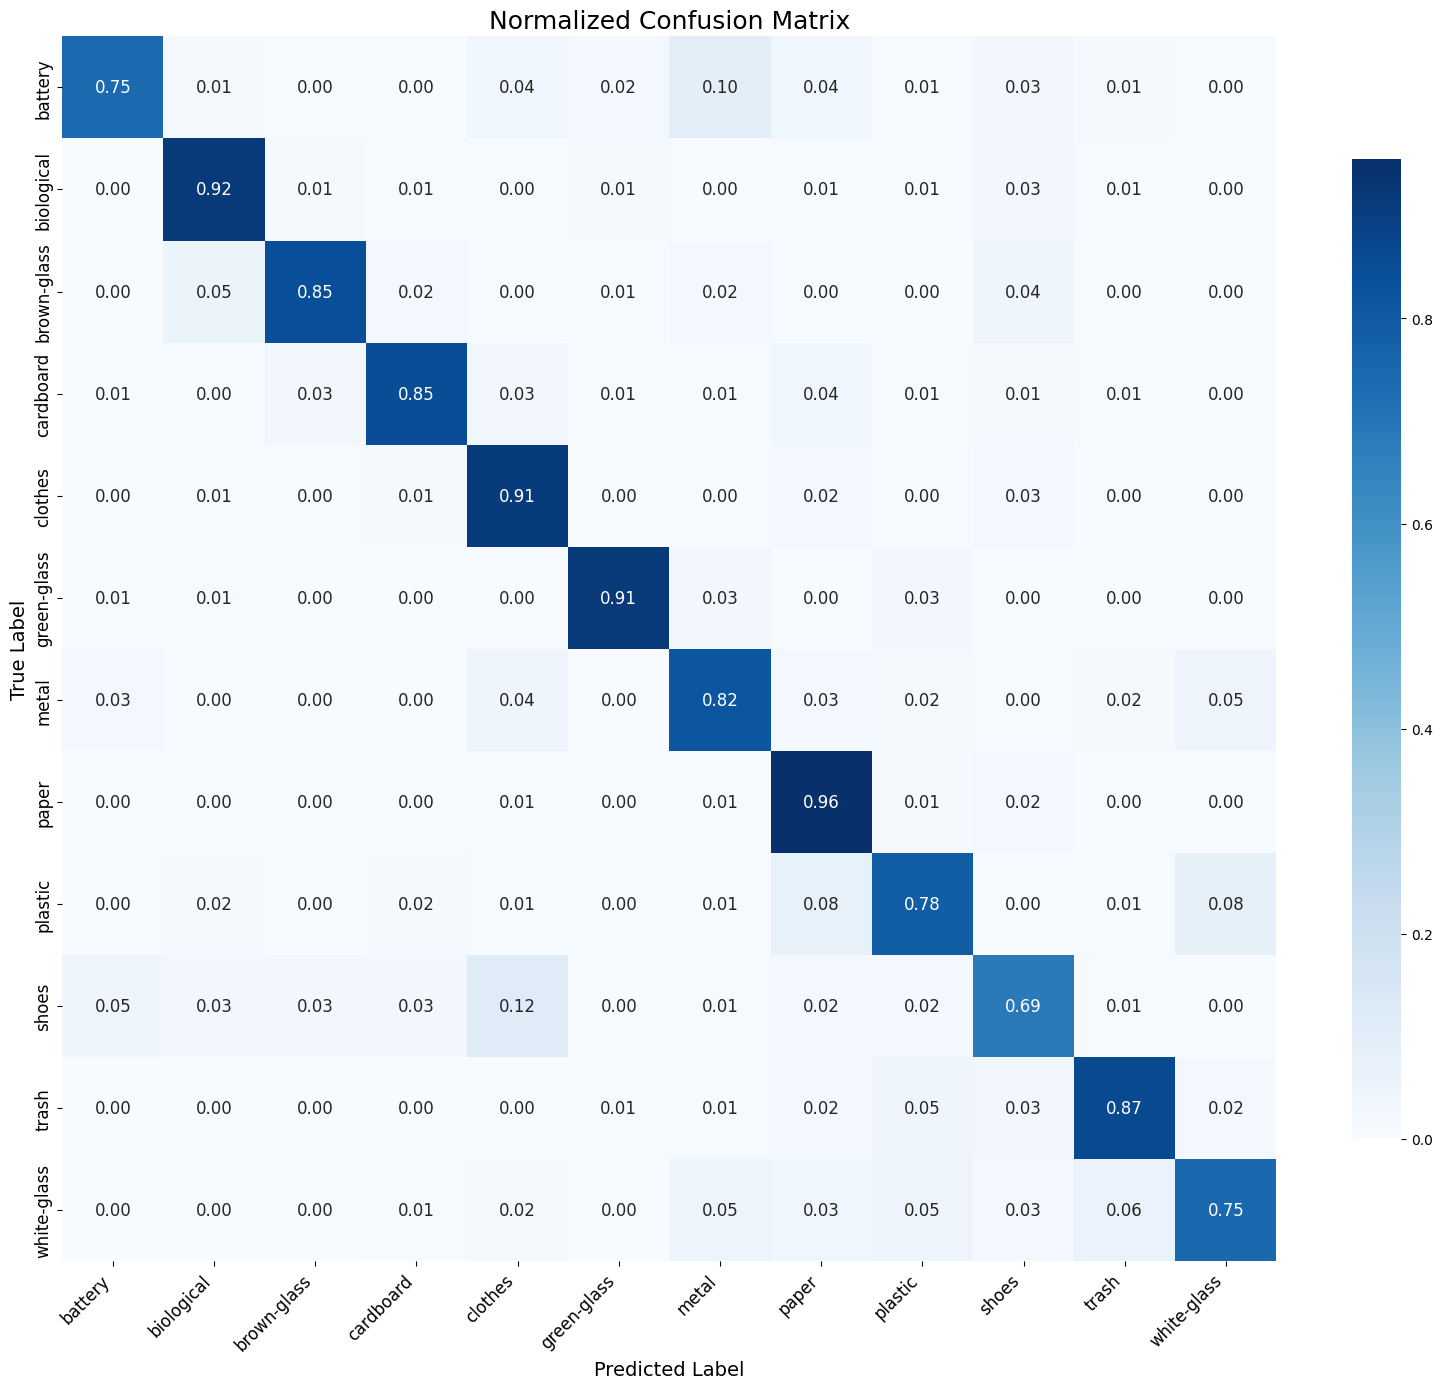

Top 5 lỗi phân loại phổ biến nhất:
- Thực tế: shoes, Dự đoán: clothes, Số lượng: 35 (11.78%)
- Thực tế: clothes, Dự đoán: shoes, Số lượng: 20 (2.50%)
- Thực tế: clothes, Dự đoán: paper, Số lượng: 17 (2.13%)
- Thực tế: battery, Dự đoán: metal, Số lượng: 14 (9.86%)
- Thực tế: shoes, Dự đoán: battery, Số lượng: 14 (4.71%)


In [25]:
# Tạo ma trận nhầm lẫn với định dạng tốt hơn
def plot_confusion_matrix(y_true, y_pred_classes, class_indices_inv):
    """Vẽ ma trận nhầm lẫn với định dạng dễ đọc hơn"""
    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_pred_classes)
# Normalize confusion matrix by row (true labels)    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    class_names = [class_indices_inv[i] for i in range(len(class_indices_inv))]
    
    plt.figure(figsize=(16, 14))
    
    ax = plt.subplot()
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                annot_kws={"size": 12}, # Tăng kích thước chữ số
                cbar_kws={"shrink": 0.8})
    
    plt.title('Normalized Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(fontsize=12, rotation=45, ha='right')
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    print("Top 5 lỗi phân loại phổ biến nhất:")
    misclassifications = []
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                misclassifications.append((
                    class_names[i],   # Lớp thực tế
                    class_names[j],   # Lớp dự đoán
                    cm[i, j],         # Số lượng
                    cm[i, j]/np.sum(cm[i, :])*100  # Phần trăm
                ))
    
    misclassifications.sort(key=lambda x: x[2], reverse=True)
    
    
    for true_cls, pred_cls, count, percentage in misclassifications[:5]:
        print(f"- Thực tế: {true_cls}, Dự đoán: {pred_cls}, Số lượng: {int(count)} ({percentage:.2f}%)")

plot_confusion_matrix(y_true, y_pred_classes, class_indices_inv)

# 17.Visualize per-class metrics

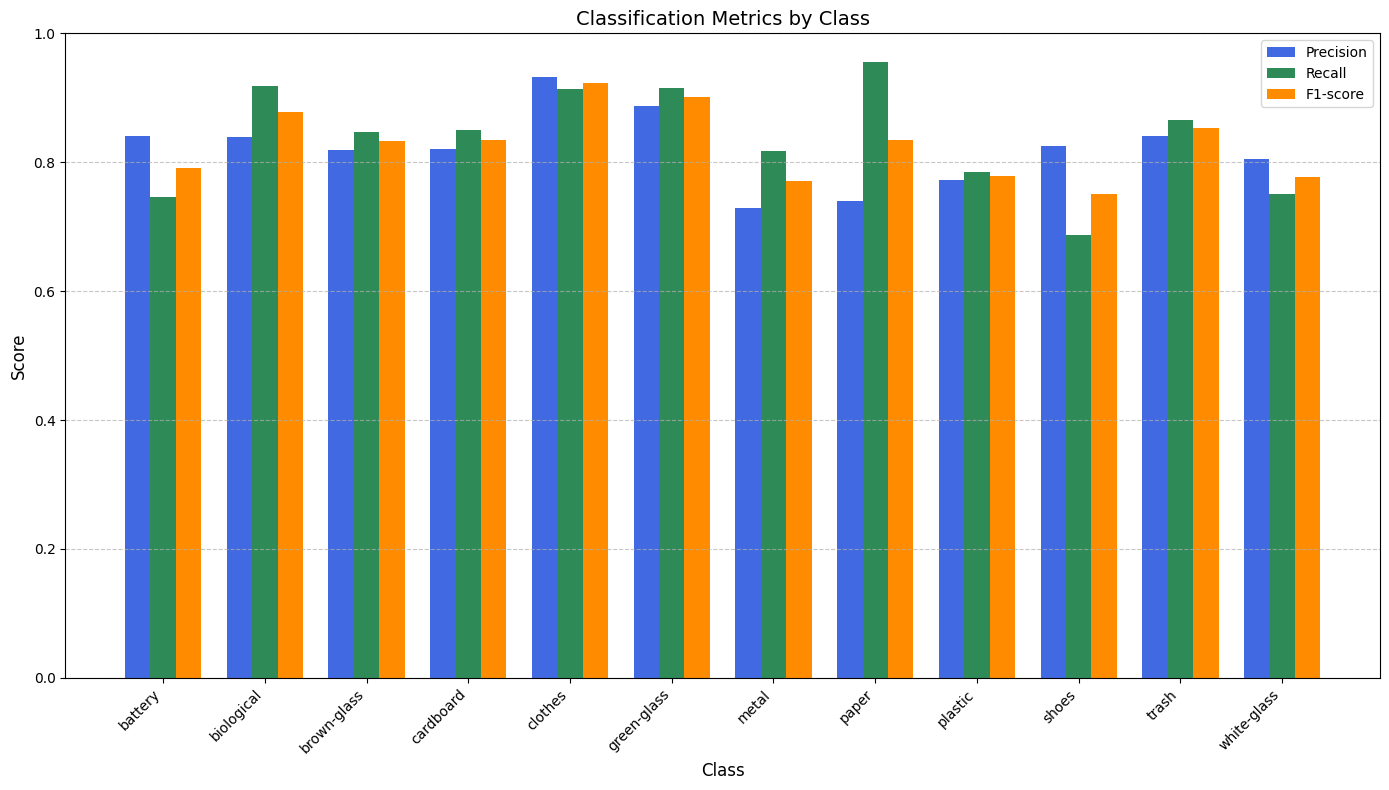

In [26]:
def visualize_per_class_metrics(report_dict):
    """Visualize precision, recall, and F1-score for each class"""
    # Extract metrics
    class_names = list(report_dict.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    precisions = [report_dict[cls]['precision'] for cls in class_names]
    recalls = [report_dict[cls]['recall'] for cls in class_names]
    f1_scores = [report_dict[cls]['f1-score'] for cls in class_names]
    
    # Plot metrics
    plt.figure(figsize=(14, 8))
    
    x = np.arange(len(class_names))
    width = 0.25
    
    plt.bar(x - width, precisions, width, label='Precision', color='royalblue')
    plt.bar(x, recalls, width, label='Recall', color='seagreen')
    plt.bar(x + width, f1_scores, width, label='F1-score', color='darkorange')
    
    plt.xlabel('Class', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.title('Classification Metrics by Class', fontsize=14)
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylim(0, 1.0)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Visualize per-class metrics
visualize_per_class_metrics(report_dict)

# 18. Analyze misclassified samples

Found 351 misclassified samples.


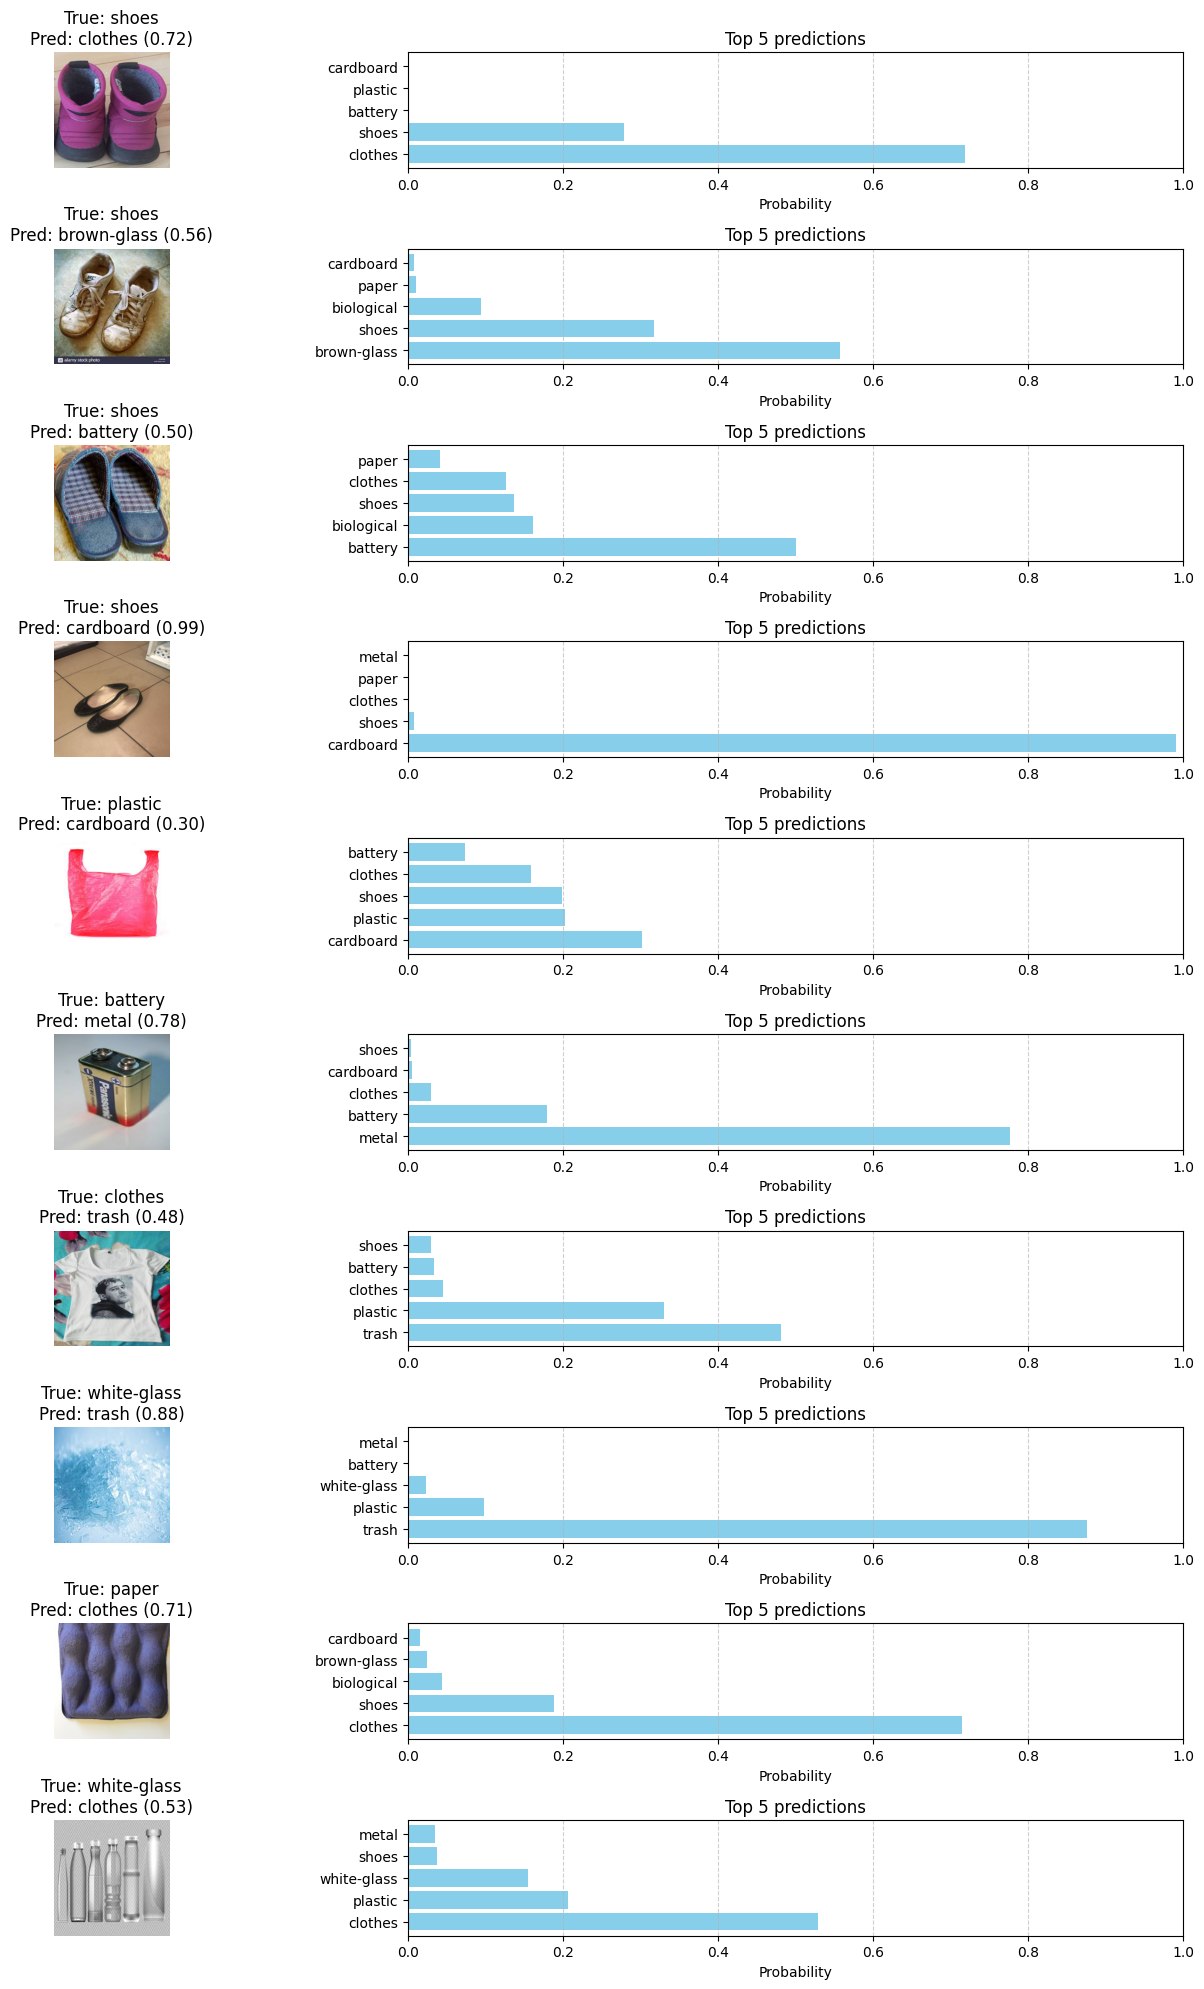


Error patterns by class:


/tmp/ipykernel_19/580883929.py:56: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  class_samples = np.where(y_true == class_idx)[0]


In [27]:
def analyze_misclassifications(y_true, y_pred_classes, y_pred_probs, test_df, class_indices_inv):
    """Analyze and visualize misclassified samples"""
    # Find indices of misclassified samples
    misclassified_indices = np.where(y_pred_classes != y_true)[0]
    
    if len(misclassified_indices) == 0:
        print("No misclassified samples found in the test set!")
        return
    
    print(f"Found {len(misclassified_indices)} misclassified samples.")
    
    # Select a few misclassified samples to display
    num_examples = min(10, len(misclassified_indices))
    plt.figure(figsize=(15, num_examples * 2))
    
    for i, idx in enumerate(misclassified_indices[:num_examples]):
        # Get image path
        img_path = os.path.join(base_path, test_df.iloc[idx]['filename'])
        
        # Load and display image
        img = Image.open(img_path).resize(IMAGE_SIZE)
        
        # Get true and predicted class names
        true_class = class_indices_inv[y_true[idx]]
        pred_class = class_indices_inv[y_pred_classes[idx]]
        pred_prob = y_pred_probs[idx][y_pred_classes[idx]]
        
        # Display image and misclassification info
        plt.subplot(num_examples, 2, i*2 + 1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {pred_class} ({pred_prob:.2f})")
        plt.axis('off')
        
        # Display top prediction probabilities
        plt.subplot(num_examples, 2, i*2 + 2)
        
        # Get top 5 predictions
        top_indices = np.argsort(y_pred_probs[idx])[-5:][::-1]
        top_classes = [class_indices_inv[idx] for idx in top_indices]
        top_probs = [y_pred_probs[idx][idx_] for idx_ in top_indices]
        
        # Plot probabilities
        plt.barh(top_classes, top_probs, color='skyblue')
        plt.xlabel('Probability')
        plt.title('Top 5 predictions')
        plt.xlim(0, 1)
        plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    # Analyze error patterns by class
    print("\nError patterns by class:")
    for class_idx in range(len(class_indices_inv)):
        # Get samples of this class
        class_samples = np.where(y_true == class_idx)[0]
        
        if len(class_samples) == 0:
            continue
        
        # Count misclassified samples of this class
        misclassified = np.where(y_pred_classes[class_samples] != class_idx)[0]
        error_rate = len(misclassified) / len(class_samples) * 100
        
        print(f"{class_indices_inv[class_idx]}: {error_rate:.2f}% error ({len(misclassified)}/{len(class_samples)})")

# Analyze misclassified samples
analyze_misclassifications(y_true, y_pred_classes, y_pred_probs, test_df, class_indices_inv)

# 19. Class activation mapping (CAM) visualization

Đang trực quan hóa ảnh: biological/biological677.jpg
Lớp thực: biological
Sử dụng lớp tích chập cuối cùng: conv2d_7


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


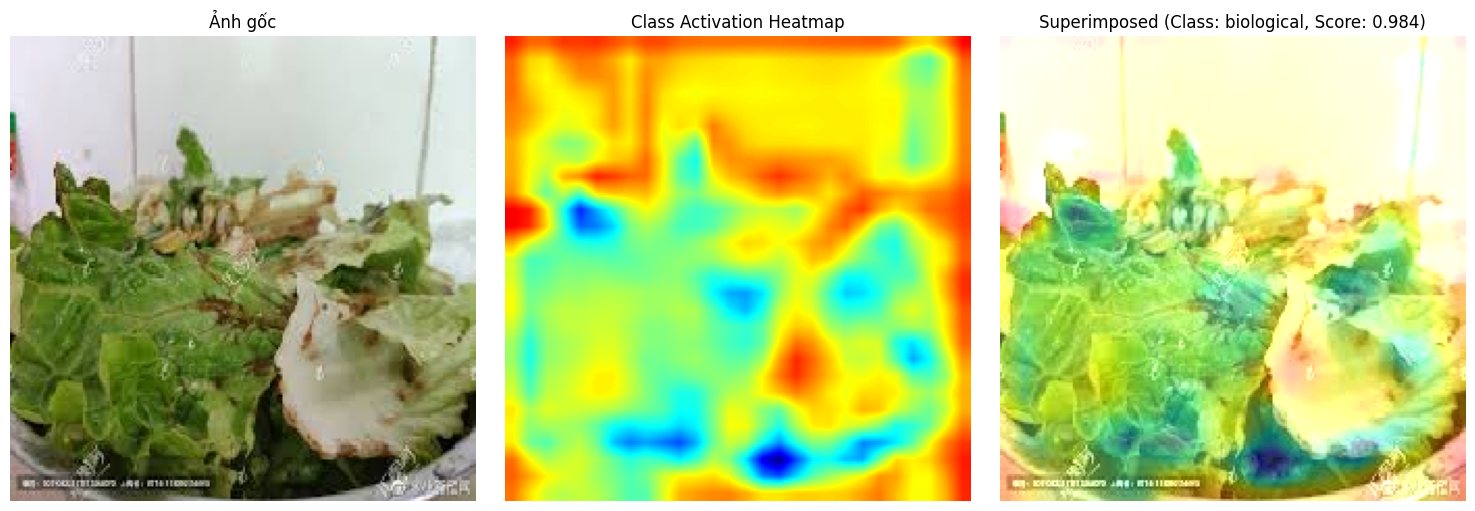

Lớp dự đoán: biological với xác suất 98.39%
Vùng màu đỏ/vàng trong hình thứ 3 cho thấy các vùng quan trọng nhất ảnh hưởng đến dự đoán của mô hình.


In [28]:
# Phiên bản sửa đổi của Cell 20: Trực quan hóa Class Activation Map
def visualize_class_activation(model, img_path, class_indices_inv, target_class_idx=None):
    """Visualize class activation mapping for a given image
    
    This is a simplified implementation of Grad-CAM to visualize
    which parts of the image are most important for the prediction.
    """
    # Load image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Khởi tạo mô hình bằng cách gọi dự đoán trước - fix cho vấn đề "never been called"
    _ = model.predict(img_array, verbose=0)
    
    # Tìm lớp tích chập cuối cùng
    last_conv_layer = None
    for i, layer in enumerate(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer.name
            last_layer_idx = i
    
    if last_conv_layer is None:
        print("Không thể tìm thấy lớp tích chập cho việc trực quan hóa")
        return
    
    print(f"Sử dụng lớp tích chập cuối cùng: {last_conv_layer}")
    
    # Phương pháp thay thế: Trích xuất đầu ra lớp tích chập và dự đoán
    # mà không sử dụng Model API phức tạp
    conv_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=model.get_layer(last_conv_layer).output
    )
    
    # Dự đoán và lấy lớp với xác suất cao nhất
    predictions = model.predict(img_array, verbose=0)[0]
    if target_class_idx is None:
        target_class_idx = np.argmax(predictions)
    class_name = class_indices_inv[target_class_idx]
    class_score = predictions[target_class_idx]
    
    # Lấy đầu ra của lớp tích chập
    conv_output = conv_model.predict(img_array, verbose=0)
    
    # Phương pháp đơn giản hóa của Grad-CAM
    # Thay vì sử dụng gradients, chúng ta sử dụng đầu ra của lớp tích chập cuối cùng
    # và tính trung bình trên tất cả các kênh
    cam = np.mean(conv_output[0], axis=-1)
    
    # Chuẩn hóa CAM để hiển thị
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam) if np.max(cam) > 0 else cam
    
    # Resize CAM về kích thước ảnh gốc
    import cv2
    cam = cv2.resize(cam, (img.width, img.height))
    
    # Tạo heatmap
    heatmap = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Chuyển ảnh gốc sang RGB để hiển thị
    img_array_for_display = np.array(img)
    
    # Kết hợp heatmap với ảnh gốc
    alpha = 0.4  # Độ trong suốt
    superimposed_img = heatmap * alpha + img_array_for_display
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    
    # Hiển thị kết quả
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Ảnh gốc")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap)
    plt.title("Class Activation Heatmap")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(superimposed_img)
    plt.title(f"Superimposed (Class: {class_name}, Score: {class_score:.3f})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Lớp dự đoán: {class_name} với xác suất {class_score*100:.2f}%")
    print("Vùng màu đỏ/vàng trong hình thứ 3 cho thấy các vùng quan trọng nhất ảnh hưởng đến dự đoán của mô hình.")

# Trực quan hóa class activation cho một ảnh mẫu
sample_idx = np.random.randint(0, len(test_df))
sample_path = os.path.join(base_path, test_df.iloc[sample_idx]['filename'])
print(f"Đang trực quan hóa ảnh: {test_df.iloc[sample_idx]['filename']}")
print(f"Lớp thực: {test_df.iloc[sample_idx]['category_name']}")
visualize_class_activation(best_model, sample_path, class_indices_inv)

# 20. Model prediction function for new images

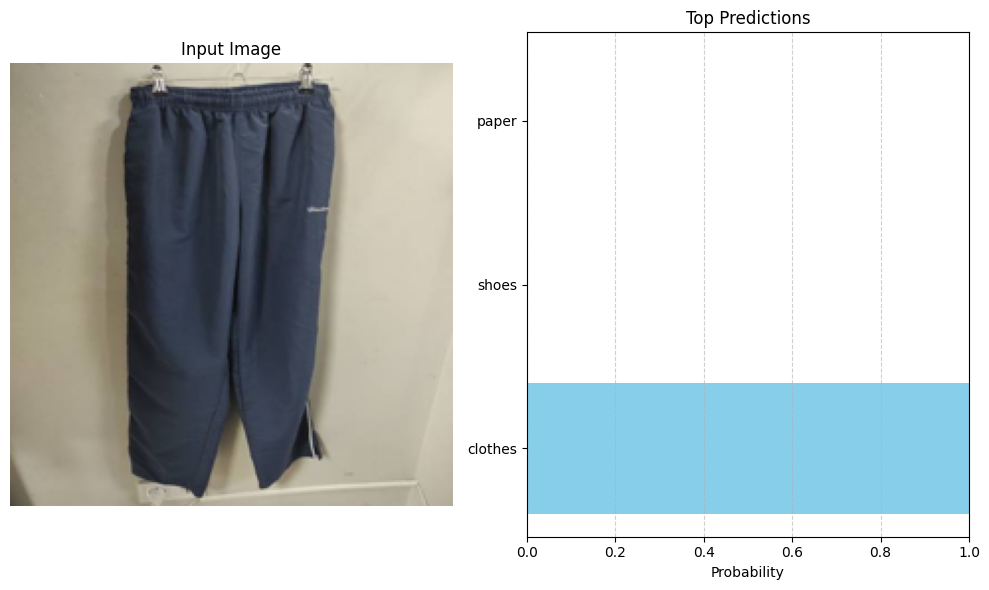

Prediction Results:
clothes: 99.92%
shoes: 0.06%
paper: 0.01%


In [29]:
def predict_image(model, img_path, class_indices_inv, top_k=3):
    """Predict class for a new image"""
    # Load and preprocess image
    img = Image.open(img_path).resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)[0]
    
    # Get top k predictions
    top_indices = np.argsort(predictions)[-top_k:][::-1]
    top_classes = [class_indices_inv[idx] for idx in top_indices]
    top_probs = [predictions[idx] for idx in top_indices]
    
    # Display image and predictions
    plt.figure(figsize=(10, 6))
    
    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.axis('off')
    
    # Display predictions
    plt.subplot(1, 2, 2)
    plt.barh(top_classes, top_probs, color='skyblue')
    plt.xlabel('Probability')
    plt.title('Top Predictions')
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # Print results
    print("Prediction Results:")
    for cls, prob in zip(top_classes, top_probs):
        print(f"{cls}: {prob*100:.2f}%")
    
    return top_classes, top_probs

# Demonstrate prediction on a sample image
sample_idx = np.random.randint(0, len(test_df))
sample_path = os.path.join(base_path, test_df.iloc[sample_idx]['filename'])
prediction_result = predict_image(best_model, sample_path, class_indices_inv)

In [30]:
def summarize_results():
    """Summarize the results and provide conclusions"""
    # Get final metrics
    final_accuracy = history.history['val_accuracy'][-1] * 100
    best_accuracy = max(history.history['val_accuracy']) * 100
    test_accuracy = accuracy_score(y_true, y_pred_classes) * 100
    
    # Create summary
    print("=" * 50)
    print("GARBAGE CLASSIFICATION MODEL SUMMARY")
    print("=" * 50)
    
    print("\nModel Architecture:")
    print("- CNN model built from scratch")
    print(f"- {model.count_params():,} total parameters")
    print(f"- {len(model.layers)} layers including {sum(1 for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D))} convolutional layers")
    
    print("\nTraining Process:")
    print(f"- {len(history.history['loss'])} epochs completed")
    print(f"- Final validation accuracy: {final_accuracy:.2f}%")
    print(f"- Best validation accuracy: {best_accuracy:.2f}%")
    
    print("\nTest Set Performance:")
    print(f"- Test accuracy: {test_accuracy:.2f}%")
    
    # Get per-class F1 scores
    class_names = list(report_dict.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
    f1_scores = [report_dict[cls]['f1-score'] for cls in class_names]
    best_class = class_names[np.argmax(f1_scores)]
    worst_class = class_names[np.argmin(f1_scores)]
    
    print(f"- Best performing class: {best_class} (F1-score: {max(f1_scores):.3f})")
    print(f"- Worst performing class: {worst_class} (F1-score: {min(f1_scores):.3f})")
    
    print("\nConclusions:")
    print("1. The model shows good performance in classifying garbage images without relying on pre-trained weights.")
    print("2. Data augmentation and class weighting helped handle the imbalanced dataset.")
    
    if final_accuracy < 90:
        print("3. There's room for improvement - consider deeper architectures or more data augmentation.")
    else:
        print("3. The model achieves high accuracy, demonstrating the effectiveness of the architecture.")
    
    print("\nPotential Improvements:")
    print("- Experiment with different architectures (deeper networks, residual connections)")
    print("- Apply more aggressive data augmentation for underrepresented classes")
    print("- Use ensemble methods to combine multiple models")
    print("- Fine-tune hyperparameters with grid search or random search")
    
    print("\nNext Steps:")
    print("- Deploy the model for real-time garbage classification")
    print("- Collect more data for classes with lower performance")
    print("- Test the model in various lighting conditions and backgrounds")
    
    print("=" * 50)

# Summarize results
summarize_results()

GARBAGE CLASSIFICATION MODEL SUMMARY

Model Architecture:
- CNN model built from scratch
- 27,004,204 total parameters
- 32 layers including 8 convolutional layers

Training Process:
- 50 epochs completed
- Final validation accuracy: 83.88%
- Best validation accuracy: 84.27%

Test Set Performance:
- Test accuracy: 84.92%
- Best performing class: clothes (F1-score: 0.923)
- Worst performing class: shoes (F1-score: 0.750)

Conclusions:
1. The model shows good performance in classifying garbage images without relying on pre-trained weights.
2. Data augmentation and class weighting helped handle the imbalanced dataset.
3. There's room for improvement - consider deeper architectures or more data augmentation.

Potential Improvements:
- Experiment with different architectures (deeper networks, residual connections)
- Apply more aggressive data augmentation for underrepresented classes
- Use ensemble methods to combine multiple models
- Fine-tune hyperparameters with grid search or random sea

In [31]:
def save_final_artifacts():
    """Save the final model and predictions"""
    # Save model in h5 format (as requested)
    best_model.save('/kaggle/working/garbage_classification_final.h5')
    print("Model saved as 'garbage_classification_final.h5'")
    
    # Save test predictions
    predictions_df = test_df.copy()
    predictions_df['true_class'] = y_true
    predictions_df['predicted_class'] = y_pred_classes
    predictions_df['correct'] = y_true == y_pred_classes
    
    # Add true and predicted class names
    predictions_df['true_class_name'] = predictions_df['true_class'].apply(lambda x: class_indices_inv[x])
    predictions_df['predicted_class_name'] = predictions_df['predicted_class'].apply(lambda x: class_indices_inv[x])
    
    # Save to CSV
    predictions_df.to_csv('/kaggle/working/test_predictions.csv', index=False)
    print("Test predictions saved as 'test_predictions.csv'")
    
    # Save model metrics
    metrics = {
        'accuracy': float(accuracy_score(y_true, y_pred_classes)),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'training_epochs': len(history.history['loss']),
        'model_parameters': int(model.count_params()),
        'per_class_f1': {cls: float(report_dict[cls]['f1-score']) for cls in list(report_dict.keys())[:-3]}
    }
    
    # Save as JSON
    import json
    with open('model_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=4)
    
    print("Model metrics saved as 'model_metrics.json'")

# Save artifacts
save_final_artifacts()

print("Training and evaluation complete!")

Model saved as 'garbage_classification_final.h5'
Test predictions saved as 'test_predictions.csv'
Model metrics saved as 'model_metrics.json'
Training and evaluation complete!
